# Quantum Error Correction Analysis Tools

*Want to follow along? {nb-download}`Download this notebook.<analysis.ipynb>`*

This page demonstrates how to analyse results from quantum error correction experiments using `Deltakit`. We will start from high-level experiment results and drill down to shot analysis.

Let's start with some common code that we will use throughout the examples.

This code generates a quantum memory experiment circuit and adds noise to it.

In [1]:
# use this code to generate the circuit locally
from deltakit.explorer.codes import css_code_memory_circuit
from deltakit.explorer.codes import RepetitionCode, RotatedPlanarCode
from deltakit.circuit.gates import PauliBasis
from deltakit.circuit import Circuit


def generate_repcode(distance: int = 3, rounds: int = 3) -> Circuit:
    # Z-stabilisers follow bit-flips, X-stabilisers follow phase-flips
    repcode = RepetitionCode(distance, stabiliser_type=PauliBasis.Z)
    # native deltakit object
    circuit = css_code_memory_circuit(repcode, num_rounds=rounds, logical_basis=PauliBasis.Z)
    return circuit

def generate_rplanar(distance: int = 3, rounds: int = 3) -> Circuit:
    # rotated planar code has stabilisers of both types, X and Z
    rplanar = RotatedPlanarCode(width=distance, height=distance)
    # native deltakit object
    circuit = css_code_memory_circuit(rplanar, num_rounds=rounds, logical_basis=PauliBasis.Z)
    return circuit

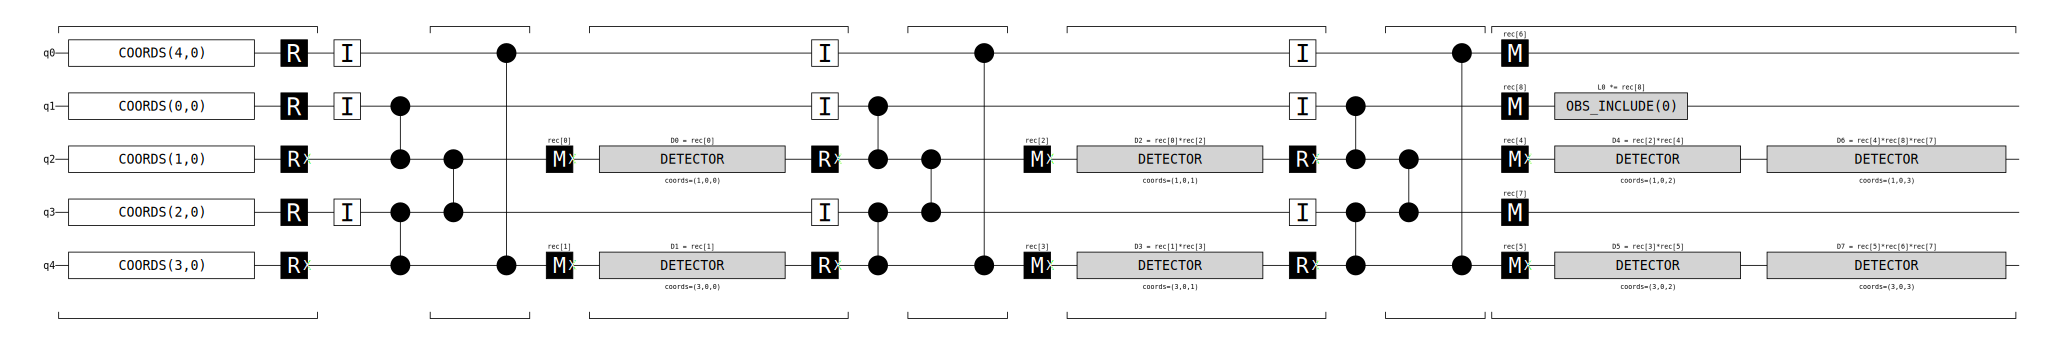

In [2]:
circuit = generate_repcode()
stim_circuit = circuit.as_stim_circuit()
stim_circuit.diagram("timeline-svg")

In [3]:
from deltakit.explorer.qpu import QPU, NativeGateSetAndTimes
from deltakit.explorer.qpu import ToyNoise
from deltakit.circuit import gates

def add_noise(circuit: Circuit, amount: float = 0.01) -> Circuit:
    qpu = QPU(
        circuit.qubits,
        native_gates_and_times=NativeGateSetAndTimes(
            # times are given (in seconds) approximately for superconducting device
            one_qubit_gates={gates.H: 20e-9, gates.SQRT_X: 20e-9},
            two_qubit_gates={gates.CZ: 30e-9},
            reset_gates={gates.RZ: 160e-9},
            measurement_gates={gates.MZ: 500e-9, gates.MRZ: 500e-9},
        ),
        noise_model=ToyNoise(p=amount)
    )
    return qpu.compile_and_add_noise_to_circuit(circuit, remove_paulis=False)

Code below samples the necessary number of shots and converts them to detector and observable values:

In [4]:
from numpy import typing as npt
import numpy as np

def get_simulated_samples(circuit: Circuit, shots: int = 10_000) -> tuple[npt.NDArray[np.uint8], npt.NDArray[np.uint8]]:
    detector_sampler = circuit.as_stim_circuit().compile_detector_sampler()
    dets, obs = detector_sampler.sample(shots, separate_observables=True)
    return dets.astype(np.uint8), obs.astype(np.uint8)

## 1. Decoder Analysis

At a very high level, we appreciate comparing things on a single scale. In decoder analysis,
there is a set of numbers that describe decoder quality and allow them to be compared.

### 1.1. Logical error probability

An obvious starting point is to measure how accurate a decoder is under fixed conditions.
In QEC, this metric is called **logical error probability** (LEP) and is computed as the proportion
of the corrected observables (i.e., observable value returned by the decoder) that is different
from the ground-truth expected observable:

$$
LEP = \frac{\Sigma_{i=1}^{N} observables^{(truth)}_i \neq observables^{(decoded)}_i}{N}
$$

You may also assess how accurate your LEP estimate is with a standard deviation estimation:

$$
\sigma_{LEP}=\sqrt{\frac{LEP \times (1 - LEP)}{N}}
$$

The smaller the $LEP$, the better are hardware and the decoder. The smaller the standard deviation, the better your estimation. You may improve standard deviation numbers by increasing the number of shots.

In [5]:
from deltakit.decode import PyMatchingDecoder
from deltakit.explorer.types import DecodingResult

circuit = generate_repcode()
noisy_circuit = add_noise(circuit, 0.01)
shots = 100_000
detectors, observables = get_simulated_samples(noisy_circuit, shots)
decoder, _ = PyMatchingDecoder.construct_decoder_and_stim_circuit(noisy_circuit)
predictions = decoder.decode_batch_to_logical_flip(detectors)
fails = int(np.sum(np.any((predictions != observables), axis=1)))
result = DecodingResult(fails=fails, shots=shots)

print(f"LEP = {result.get_logical_error_probability():.5f} ± {result.get_standard_deviation():.5f}")

LEP = 0.00289 ± 0.00017


In Quantum Memory experiments, you try to preserve a qubit in the state it was initialised.
The longer you do this, the more physical errors accumulate, thus the greater the chance for the decoder to make a mistake.
The theoretical model states that every error correction round increases the probability of a logical error by a factor known as the **logical error probability per round** $\epsilon$.
You may also find it under the name "logical error probability per round".
Note: doing no rounds means your LEP is equal to a logical **state preparation and measurement** (SPAM) error. Thus:

$$
LEP(0) = P_{SPAM}
$$
$$
1 - LEP(n)=(1 - \epsilon)\cdot(1 - LEP(n-1)) =
$$
$$
= (1 - P_{SPAM})\cdot(1 - \epsilon)^{n}
$$

If you run an experiment multiple times with different numbers of rounds, then you can fit an exponential curve to estimate $\epsilon$.

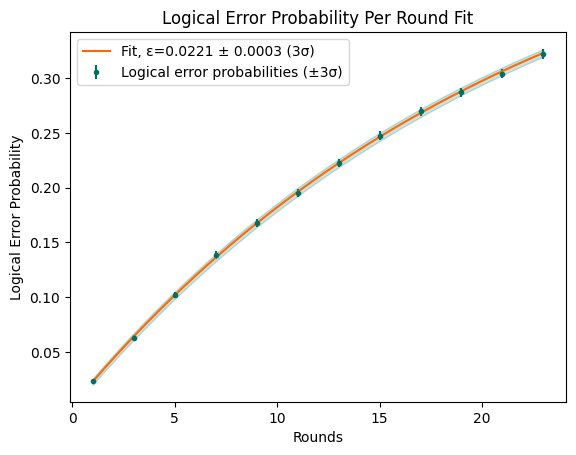

In [6]:
import numpy as np
from deltakit.explorer.plotting import plot_logical_error_probability_per_round
from deltakit.explorer.analysis import calculate_lep_and_lep_stddev, compute_logical_error_per_round
from matplotlib import pyplot as plt

rounds_list = list(range(1, 24, 2))
shots = 100_000

leps: list[float] = []
lep_stddevs: list[float] = []
for rounds in rounds_list:
    circuit = generate_repcode(distance=3, rounds=rounds)
    noisy_circuit = add_noise(circuit, 0.05)
    detectors, observables = get_simulated_samples(noisy_circuit, shots)
    decoder, _ = PyMatchingDecoder.construct_decoder_and_stim_circuit(noisy_circuit)
    predictions = decoder.decode_batch_to_logical_flip(detectors)
    fails = int(np.sum(np.any((predictions != observables), axis=1)))
    lep, lep_stddev = calculate_lep_and_lep_stddev([fails], [shots])
    leps.append(lep[0])
    lep_stddevs.append(lep_stddev[0])

leppr_results = compute_logical_error_per_round(rounds_list, leps, lep_stddevs)
fig, ax = plot_logical_error_probability_per_round(leppr_results, rounds_list, leps, lep_stddevs)
plt.show()

### 1.2. Threshold

A decoder may perform very well on small **code sizes**, or in particular **noise regimes**.
It is useful to see how performance changes with changing conditions.

The [Threshold theorem](https://en.wikipedia.org/wiki/Threshold_theorem) suggests that logical error probability per round should exponentially decrease with the size of the code,
but beyond *some* physical noise level this law flips, and adding more qubits leads to even worse logical errors.
The point (amount of physical noise) where this happens is called a **threshold**. This number characterises
how ready particular codes and decoders are for the noise level of real hardware. The bigger the threshold, the better.

To compute a threshold, you will have to run QEC experiments with different noise levels and code sizes.

distances: 100%|██████████| 3/3 [01:05<00:00, 21.95s/it]


threshold = 0.17


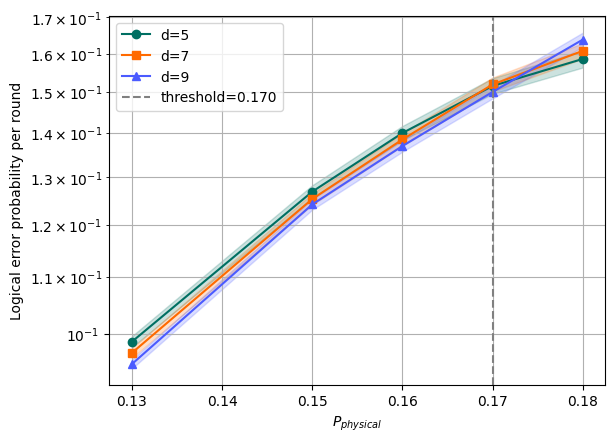

In [7]:
from tqdm import tqdm
from deltakit_explorer.analysis import compute_logical_error_per_round
from deltakit.core.plotting.colours import RIVERLANE_PLOT_COLOURS

rounds_list = [1, 3, 5, 7, 9]
distances = [5, 7, 9]
probabilities = [0.13, 0.15, 0.16, 0.17, 0.18]

shots = 100_000
distance_to_leppr: dict[int, list[float]] = {}
distance_to_leppr_stddev: dict[int, list[float]] = {}

for i, distance in enumerate(tqdm(distances, desc="distances")):
    distance_to_leppr[distance] = []
    distance_to_leppr_stddev[distance] = []
    for prob in probabilities:
        leps: list[float] = []
        lep_stddevs: list[float] = []
        for rounds in rounds_list:
            circuit = generate_repcode(distance=distance, rounds=rounds)
            noisy_circuit = add_noise(circuit, prob)
            detectors, observables = get_simulated_samples(noisy_circuit, shots)
            decoder, _ = PyMatchingDecoder.construct_decoder_and_stim_circuit(noisy_circuit)
            predictions = decoder.decode_batch_to_logical_flip(detectors)
            fails = int(np.sum(np.any((predictions != observables), axis=1)))

            lep, lep_stddev = calculate_lep_and_lep_stddev([fails], [shots])
            leps.append(lep[0])
            lep_stddevs.append(lep_stddev[0])

        res = compute_logical_error_per_round(rounds_list, leps, lep_stddevs)
        leppr, leppr_stddev = res.leppr, res.leppr_stddev
        distance_to_leppr[distance].append(leppr)
        distance_to_leppr_stddev[distance].append(leppr_stddev)

    markers = ["o", "s", "^"]
    plt.plot(
        probabilities,
        distance_to_leppr[distance],
        label=f"d={distance}",
        color=RIVERLANE_PLOT_COLOURS[i],
        marker=markers[i]
    )
    plt.fill_between(
        probabilities,
        np.array(distance_to_leppr[distance]) - np.array(distance_to_leppr_stddev[distance]),
        np.array(distance_to_leppr[distance]) + np.array(distance_to_leppr_stddev[distance]),
        color=RIVERLANE_PLOT_COLOURS[i], alpha=0.2
    )

lines = np.array(list(distance_to_leppr.values()), dtype=np.float64)
# Note: this is a numerical estimation, resolution is defined by the error step.
# Result is a physical error probability with the smallest variance of LER.
# For accurate estimation of a threshold you may fit LER curve and
# derive an interpolated value.
threshold = probabilities[lines.std(axis=0).argmin()]
print(f"threshold = {threshold}")
plt.axvline(x=threshold, color="gray", linestyle="--", label=f"threshold={threshold:.3f}")

plt.xlabel("$P_{physical}$")
plt.ylabel("Logical error probability per round")
plt.yscale("log")
plt.grid(True, which = 'both')
plt.legend()
plt.show()

### 1.3. Error scaling parameter $\Lambda$

Another way to see how the decoder responds to changes in code size is to take a vertical slice of the threshold plot.
If you set the noise level as a constant $p_0$, you may see how well the decoder's logical error probability per round improves
with code size change. The threshold theorem assumes this satisfies the exponential law:

$$
\epsilon_{d}=\frac{\epsilon_{d-2}}{\Lambda}=p_0\cdot\Lambda^{-\frac{d+1}{2}}
$$

The $\Lambda$ factor here is referred to as the **error scaling parameter**. This parameter is considered to be a very important
integral metric for near-future error-corrected QPUs: larger $\Lambda$ means a higher suppression of errors, and will allow for fewer qubits 
to achieve the promised logical error level.

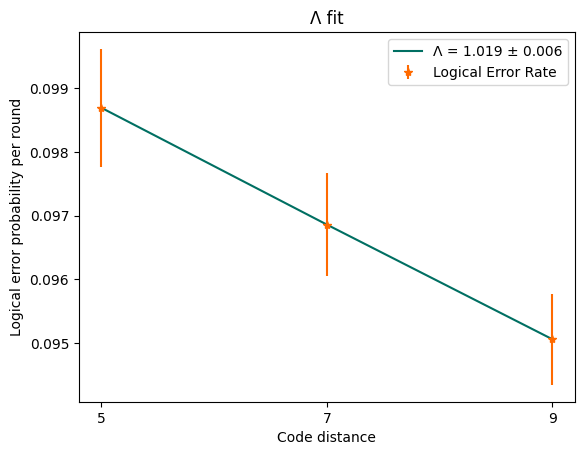

In [8]:
from deltakit_explorer.analysis import calculate_lambda_and_lambda_stddev, get_lambda_fit

noise_index = 0
probs = [eps[noise_index] for eps in distance_to_leppr.values()]
errors = [std[noise_index] for std in distance_to_leppr_stddev.values()]
lambda_result = calculate_lambda_and_lambda_stddev(distances, probs, errors)
lambda_, lambda_stddev = lambda_result.lambda_, lambda_result.lambda_stddev

fitted_curve = get_lambda_fit(distances, probs, errors)
plt.plot(distances, fitted_curve, color=RIVERLANE_PLOT_COLOURS[0], label=f"Λ = {lambda_:.3f} ± {lambda_stddev:.3f}")
plt.errorbar(distances, probs, yerr=errors, color=RIVERLANE_PLOT_COLOURS[1], label="Logical Error Rate", ls="", marker="*")
plt.xticks(distances)
plt.title("Λ fit")
plt.xlabel("Code distance")
plt.ylabel("Logical error probability per round")
plt.legend()
plt.show()

### 1.4. Running an experiment with a `RunAllAnalysisEngine` object

As you can see, computing these values requires running a grid search in a parameter space.
Deltakit provides convenience classes to build a large experiment from smaller ones.

We will run a toy example which has 2 observables.

In [9]:
from deltakit_decode.analysis import RunAllAnalysisEngine, StimDecoderManager
from deltakit_circuit import MeasurementRecord, Observable

managers = []
err = 0.05
for distance in [3, 5, 7]:
    circuit = generate_repcode(distance=distance, rounds=distance)
    # add another observable (qubit choice is not justified at all!)
    circuit.append_layers([Observable(1, MeasurementRecord(-2))])
    noisy_circuit = add_noise(circuit, err)
    decoder, circuit = PyMatchingDecoder.construct_decoder_and_stim_circuit(noisy_circuit)
    managers.append(
        StimDecoderManager(
            circuit,
            decoder,
            metadata={
                "Code": "repetition_code",
                "Basis": PauliBasis.Z.name,
                "Distance": distance,
                "Num Rounds": distance,
                "Physical Error": err,
            },
        )
    )
engine = RunAllAnalysisEngine(
    experiment_name=f"Repcode p_error={err}",
    decoder_managers=managers,
    max_shots=1_000_000,
    batch_size=10_000,
    # Early stopping: we got enough errors
    loop_condition=RunAllAnalysisEngine.loop_until_failures(10),
    num_parallel_processes=2,
)
report = engine.run()
report = report.drop(columns=["decoder", "noise_name", "Code", "Basis"])
display(report)

Evaluating codes: 100%|██████████| 3/3 [00:00<00:00, 34.39it/s]


,shots,fails,Distance,Num Rounds,Physical Error,fails_log_0,fails_log_1
0,20000,1326,3,3,0.05,1326,1326
1,20000,1048,5,5,0.05,1048,1048
2,20000,828,7,7,0.05,828,828


If the reported data is not sufficient, you may ask each `DecoderManager` about individual error distributions. In the plot below, you may see that
decoding failures are fully correlated, as there are no failures that involve observable 0 but do not involve observable 1.

{'Code': 'repetition_code', 'Basis': 'Z', 'Distance': 7, 'Num Rounds': 7, 'Physical Error': 0.05}
[[19172     0]
 [    0   828]]


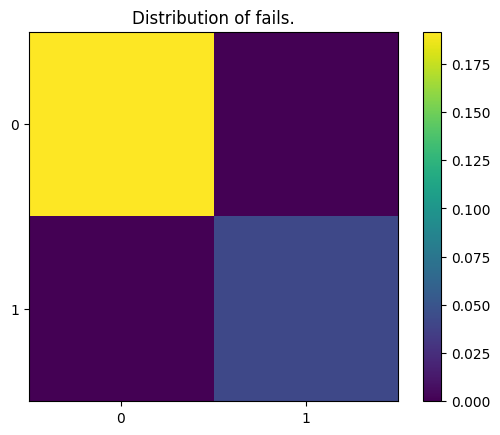

In [10]:
from deltakit_decode.analysis import EmpiricalDecodingErrorDistribution

manager = engine.decoder_managers[2]
print(manager.metadata)
distribution: EmpiricalDecodingErrorDistribution = manager.empirical_decoding_error_distribution
print(distribution._error_distribution.reshape(2, 2))
plt.imshow(
    distribution._error_distribution.reshape(2, 2) / distribution.shots,
    vmax=max(distribution._error_distribution / shots),
)
plt.xticks([0, 1])
plt.yticks([0, 1])
plt.colorbar()
plt.title("Distribution of fails.")
plt.show()

## 2. QPU analysis: defect rates and detector correlations

In QEC, we use detectors to track physical qubit errors.
Qubit readout is typically a destructive operation,
but you can observe associated detectors.
You may analyse experimental data and derive defect rates.

A defect rate is the probability that a given detector flips at a given point in time during an experiment. For a set of detectors, you can calculate the defect rates using the `deltakit.explorer.Client.defect_rates` method.

The arguments are the detector measurement results and the Stim circuit. The output from this function is a dictionary of each coordinate specified and a list of the probability that it flipped during each round of quantum error correction. This can be then visualised.

An average defect rate across all measurement rounds can be visualised using `deltakit.explorer.visualisation.defect_rates`.

The first argument is the list of experiments defect rates. The second argument is a set of detector coordinates which are weight-2, meaning that they only detect errors on two physical qubits. This is to distinguish them from the weight-4 detectors, which detect errors on four physical qubits. On the surface code, weight-2 detectors usually exist on the boundaries of the code, and weight-4 detectors exist in the bulk. Note, that for a repetition code, all detectors are weight-2.

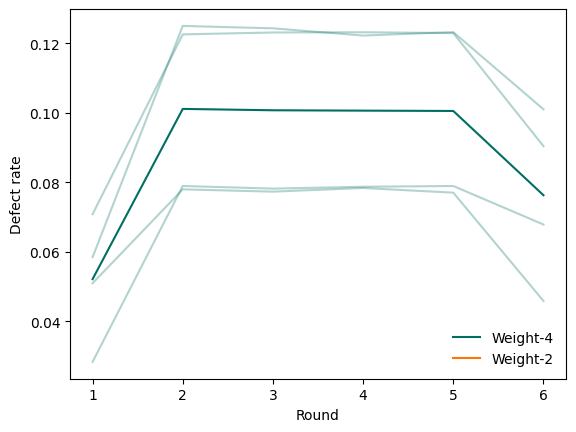

In [11]:
from deltakit_explorer import Client, types, plotting
w2_det_coords={(5, 6), (1, 4), (4, 3), (2, 7)}

cloud = Client.get_instance()

circuit = generate_rplanar(3, 5)
noisy = add_noise(circuit, 0.01)
dets, obs = get_simulated_samples(noisy, 100_000)
experiment = types.QECExperiment(
    noisy_circuit=str(noisy.as_stim_circuit()),
    detectors=types.DetectionEvents(dets),
    observables=types.ObservableFlips(obs),
)

_, rates = cloud.get_experiment_detectors_and_defect_rates(experiment)
plotting.defect_rates([rates], w2_det_coords=w2_det_coords).show()

Some detectors are correlated:
they may oversee the same qubit and track the same flips on it.
These correlations are theoretically expected.
Other detectors may correlate due to unaccounted
factors in real hardware:
for example, superconducting cross-talk or Y-biased noise.

Correlation matrix plots show expected and unexpected correlations. You would expect detectors to
correlate with their direct neighbours (see coordinates), or with themselves on consecutive rounds
(consider each small plot on a diagonal). Outliers may be interesting to you.
These can be generated through `deltakit.explorer.Client.get_correlation_matrix` and shown with `deltakit.explorer.visualisation.correlation_matrix`.

The flag `use_default_noise_model_edges` is a boolean value which specifies what correlations to look for. If set to `True`, the correlation matrix will only show correlated errors between connected qubits: if errors on the two qubits can flip the same detector in the noise model.

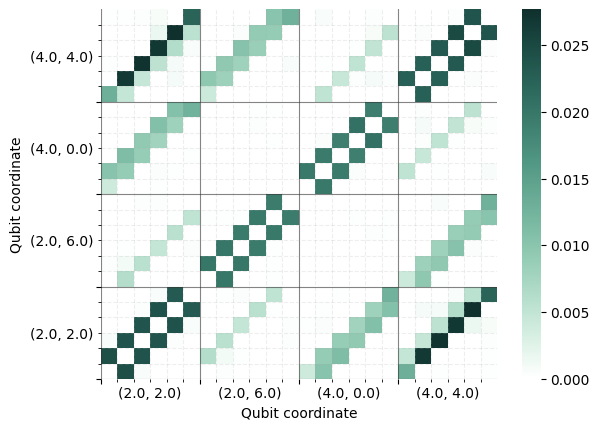

In [12]:
matrix, mapping = cloud.get_correlation_matrix(
    types.DetectionEvents(dets), noisy.as_stim_circuit(),
    use_default_noise_model_edges=False,
)
plotting.correlation_matrix(matrix, mapping).show()

In this notebook, you've explored a range of quantum error correction analysis tools available in Deltakit.
Starting from high-level experiment results, you've computed logical error probability per round, threshold, and error scaling parameter.
You then drilled down to tools for detailed error distribution analysis and experiment automation tools.
At the low level, you've analysed defect rates and detector correlations to gain deeper insight into physical error mechanisms.

Here are some takeaways from this document:

- Deltakit enables users to assess decoder performance, error rates, and scaling behaviour across different codes and noise regimes.
- Decoder managers and analysis engines streamline large-scale experiments and data collection.
- Defect rate and correlation analysis help identify hardware issues and unexpected error sources.
- Tools integrate with STIM and support both simulation and experimental data.
- Built-in plotting functions make it easy to interpret results and compare decoders.